<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Predicting Movie Box Office Revenue (Part 3 - Modelling)

## Table of Contents

- [Import libraries](#Import-libraries)
- [Preprocessing](#Preprocessing)
- [Modelling](#Modelling)
    - [Evaluating models with default parameters](#Evaluating-models-with-default-parameters)
    - [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Conclusion](#Conclusion)

## Import libraries

In [1]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

#import additional gb models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#set notebook parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 60)

In [2]:
df = pd.read_csv('../data/cleaned_df')

In [3]:
df.head(3)

,budget,original_language,revenue,runtime,vote_average,vote_count,top_50_production_companies,top_5_production_countries,top_5_spoken_languages,top_100_cast,top_20_directors,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,years_released
0,75000000,English,161000000,104,6.4,1314,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.0
1,74000000,English,164289828,112,6.7,885,1,1,1,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0
2,110000000,English,375000000,122,7.7,1760,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3902 entries, 0 to 3901
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   budget                       3902 non-null   int64  
 1   original_language            3902 non-null   object 
 2   revenue                      3902 non-null   int64  
 3   runtime                      3902 non-null   int64  
 4   vote_average                 3902 non-null   float64
 5   vote_count                   3902 non-null   int64  
 6   top_50_production_companies  3902 non-null   int64  
 7   top_5_production_countries   3902 non-null   int64  
 8   top_5_spoken_languages       3902 non-null   int64  
 9   top_100_cast                 3902 non-null   int64  
 10  top_20_directors             3902 non-null   int64  
 11  Action                       3902 non-null   int64  
 12  Adventure                    3902 non-null   int64  
 13  Animation         

## Preprocessing

#### One-hot encoding

In [5]:
#one-hot encode categorical columns
df = pd.get_dummies(data=df, columns=['original_language'], drop_first=True)

#### Train-test-split

In [6]:
#define X/y variables:
X = df.drop('revenue',axis=1)
y = df['revenue']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (3121, 31)
X_test: (781, 31)


#### Variable scaling

Our numeric features are not quite normally distributed, therefore we will use the MinMaxScaler to scale our feature variables.

In [8]:
#min-max scale features
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)

## Modelling

In [9]:
#function to run model

def run_model(model,modelname, X_train, X_test, y_train, y_test):

    #Fit model
    model.fit(X_train,y_train)
    
    #Predict
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    
    #metrics
    r2_train = r2_score(y_train, y_preds_train)
    r2_test = r2_score(y_test, y_preds_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_preds_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_preds_test))
    
    print(modelname)
    print(u'\u2500' * 30)
    print(modelname, f"train RMSE: ", rmse_train)
    print(modelname, f"test RMSE: ", rmse_test)
    print(modelname, f"train R2 score: ", r2_train)
    print(modelname, f"test R2 score: ", r2_test)

#### Null model

In [10]:
#Predicting based on mean
dummy = DummyRegressor()
run_model(dummy, 'Dummy Model', X_train, X_test, y_train, y_test)

Dummy Model
──────────────────────────────
Dummy Model train RMSE:  128595538.60487163
Dummy Model test RMSE:  135663432.03449133
Dummy Model train R2 score:  0.0
Dummy Model test R2 score:  -0.0004915083487890826


The null model did badly with a high RMSE score of 135,663,432, and a slightly negative R2 score.

### Evaluating models with default parameters

We will evaluate the performance of a few models using the default hyperparameters to identify the potential models for further hyperparameter tuning.

#### Linear Regression model (base model)

In [11]:
lr = LinearRegression()
run_model(lr,'Linear Regression Model', X_train, X_test, y_train, y_test)

Linear Regression Model
──────────────────────────────
Linear Regression Model train RMSE:  77320017.63256599
Linear Regression Model test RMSE:  78276663.75121334
Linear Regression Model train R2 score:  0.6384802023389938
Linear Regression Model test R2 score:  0.6669170350380136


#### K Nearest Neighbours model

In [12]:
knn = KNeighborsRegressor()
run_model(knn,'K Nearest Neighbours Model', X_train_scaled, X_test_scaled, y_train, y_test)

K Nearest Neighbours Model
──────────────────────────────
K Nearest Neighbours Model train RMSE:  78768088.20435749
K Nearest Neighbours Model test RMSE:  92098270.09345272
K Nearest Neighbours Model train R2 score:  0.6248121153362334
K Nearest Neighbours Model test R2 score:  0.5389046387715926


#### Random Forest model

In [13]:
rf = RandomForestRegressor(random_state=42)
run_model(rf,'Random Forest Model', X_train, X_test, y_train, y_test)

Random Forest Model
──────────────────────────────
Random Forest Model train RMSE:  27429799.229289826
Random Forest Model test RMSE:  71189341.76671922
Random Forest Model train R2 score:  0.954501879759099
Random Forest Model test R2 score:  0.7245024365520127


#### Adaboost model

In [14]:
ada = AdaBoostRegressor(random_state=42)
run_model(ada,'Adaboost Model', X_train, X_test, y_train, y_test)

Adaboost Model
──────────────────────────────
Adaboost Model train RMSE:  100877848.37876146
Adaboost Model test RMSE:  106212763.59367463
Adaboost Model train R2 score:  0.38462504407499265
Adaboost Model test R2 score:  0.38674481947229733


#### Support Vector model

In [15]:
svr = SVR()
run_model(svr, 'Support Vector Model', X_train_scaled, X_test_scaled, y_train, y_test)

Support Vector Model
──────────────────────────────
Support Vector Model train RMSE:  136705675.82927135
Support Vector Model test RMSE:  144343864.63306692
Support Vector Model train R2 score:  -0.1301114860240029
Support Vector Model test R2 score:  -0.13262062314701617


#### XGBoost model

In [16]:
xgb = XGBRegressor(random_state=42)
run_model(xgb, 'XGBoost Model', X_train, X_test, y_train, y_test)

XGBoost Model
──────────────────────────────
XGBoost Model train RMSE:  18418106.06035198
XGBoost Model test RMSE:  71211282.52185196
XGBoost Model train R2 score:  0.9794865770024521
XGBoost Model test R2 score:  0.7243325921367005


#### LightGBM model

In [17]:
lgbm = LGBMRegressor(random_state=42)
run_model(lgbm, 'LightGBM Model', X_train, X_test, y_train, y_test)

LightGBM Model
──────────────────────────────
LightGBM Model train RMSE:  41334640.435101
LightGBM Model test RMSE:  69166665.04373023
LightGBM Model train R2 score:  0.8966818729529321
LightGBM Model test R2 score:  0.7399352564496455


#### CatBoost model

In [18]:
cb = CatBoostRegressor(random_state=42, verbose=False)
run_model(cb, 'CatBoost Model', X_train, X_test, y_train, y_test)

CatBoost Model
──────────────────────────────
CatBoost Model train RMSE:  35566348.51259714
CatBoost Model test RMSE:  67748723.86896738
CatBoost Model train R2 score:  0.9235061084011548
CatBoost Model test R2 score:  0.750488799493146


Based on the models that we ran, Random Forest, XGBoost, LightGBM and CatBoost had the better metric performance in terms of RMSE score and R2 scores. Also, there were signs of overfitting. We will tune the hyperparameters  on these 4 models and reevaluate their performance.

### Hyperparameter Tuning

In [19]:
#dict of models to tune hyperparameters
model_dict = {
    'rf': RandomForestRegressor(random_state=42),
    'xgb': XGBRegressor(random_state=42),
    'lgbm': LGBMRegressor(random_state=42),
    'cb': CatBoostRegressor(random_state=42, verbose=False)
}

#dict of hyperparameters to be tuned for each model
params_dict = {
    'rf': {'n_estimators': [100,350],
           'max_depth': [25],
           'max_features': ['auto']
          },
    
    'xgb': {'n_estimators': [500,650],
            'max_depth': [6],
            'learning_rate': [0.01,0.1],
            'reg_alpha': [1,5],
            'reg_lambda': [1,10],
            'gamma': [0.01,0.1]
           },
    
    'lgbm': {'n_estimators': [300,450],
             'max_depth': [10,15],
             'learning_rate': [0.01,0.1]
            },
    
    'cb': {'n_estimators': [300,500],
           'max_depth': [4,8],
           'learning_rate': [0.05,0.1]
    }
}

In [21]:
#function to tune model hyperparameters

def tune_model(model, 
               modelname, 
               model_dict=model_dict, 
               params_dict=params_dict,
               X_train=X_train, 
               X_test=X_test, 
               y_train=y_train, 
               y_test=y_test):

    #define instantiator and hyperparameters for tuning in GridSearchCV
    gs_model = model_dict[model]
    gs_param = params_dict[model]
    
    #Instantiate GridSearchCV
    gs = GridSearchCV(gs_model, param_grid=gs_param, cv=5, scoring='r2', verbose=1)
    
    #Fit model
    gs.fit(X_train,y_train)
    
    #Predict
    y_preds_train = gs.predict(X_train)
    y_preds_test = gs.predict(X_test)
    
    #metrics
    r2_train = r2_score(y_train, y_preds_train)
    r2_test = r2_score(y_test, y_preds_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_preds_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_preds_test))
    
    print('')
    print(f"Optimized hyperparameters: {gs.best_params_}")
    print('')
    print(modelname)
    print(u'\u2500' * 30)
    print(modelname, f"train RMSE: ", rmse_train)
    print(modelname, f"test RMSE: ", rmse_test)
    print(modelname, f"train R2 score: ", r2_train)
    print(modelname, f"test R2 score: ", r2_test)
    print('')

#### Random Forest model

In [22]:
%%time
tune_model('rf','Random Forest Model')

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Optimized hyperparameters: {'max_depth': 25, 'max_features': 'auto', 'n_estimators': 350}

Random Forest Model
──────────────────────────────
Random Forest Model train RMSE:  26985089.47250132
Random Forest Model test RMSE:  71065163.90988877
Random Forest Model train R2 score:  0.955965210848354
Random Forest Model test R2 score:  0.7254627168055893

CPU times: user 42.2 s, sys: 249 ms, total: 42.4 s
Wall time: 42.5 s


#### XGBoost model

In [23]:
%%time
tune_model('xgb','XGBoost Model')

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Optimized hyperparameters: {'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 650, 'reg_alpha': 5, 'reg_lambda': 10}

XGBoost Model
──────────────────────────────
XGBoost Model train RMSE:  47539232.80769251
XGBoost Model test RMSE:  67952085.64065495
XGBoost Model train R2 score:  0.8633365015635903
XGBoost Model test R2 score:  0.7489886326490052

CPU times: user 35min 17s, sys: 3min 12s, total: 38min 29s
Wall time: 5min 26s


#### LightGBM model

In [24]:
%%time
tune_model('lgbm','LightGBM Model')

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Optimized hyperparameters: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 450}

LightGBM Model
──────────────────────────────
LightGBM Model train RMSE:  52203605.22384338
LightGBM Model test RMSE:  68576515.30039635
LightGBM Model train R2 score:  0.8352030422864658
LightGBM Model test R2 score:  0.7443542171195994

CPU times: user 1min 52s, sys: 6.73 s, total: 1min 59s
Wall time: 16.2 s


#### CatBoost model

In [25]:
%%time
tune_model('cb','CatBoost Model')

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Optimized hyperparameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300}

CatBoost Model
──────────────────────────────
CatBoost Model train RMSE:  43801703.79403303
CatBoost Model test RMSE:  66909178.336045735
CatBoost Model train R2 score:  0.8839807097307099
CatBoost Model test R2 score:  0.7566343940772329

CPU times: user 1min 44s, sys: 29.1 s, total: 2min 13s
Wall time: 43.8 s


#### Summary of results

The table below is the compilation of the RMSE and R2 scores of the various optimized models.

|Model|Train RMSE|Test RMSE|Train R2|Test R2
|---|---|---|---|---|
|Random Forest|26985089.47|71065163.91|0.9560|0.7255
|XGBoost|47539232.81|67952085.64|0.8633|0.7490
|LightGBM|52203605.22|68576515.30|0.8352|0.7444
|CatBoost|43801703.79|66909178.34|0.8840|0.7566

The gradient boosting models performed better as compared to the random forest model and achieved comparable performance. CatBoost was selected as the final model as it had the highest R2 score of 0.7566, with a reasonably lower RMSE score of 69,251,600 as well.

In [26]:
#instantiate final model
final_model = CatBoostRegressor(n_estimators=300,
                               max_depth=8,
                               learning_rate=0.05)

final_model.fit(X_train,y_train)

0:	learn: 125244774.3569927	total: 5.04ms	remaining: 1.51s
1:	learn: 121954958.1519930	total: 10.9ms	remaining: 1.62s
2:	learn: 118749989.2191503	total: 15.4ms	remaining: 1.52s
3:	learn: 115931905.3223780	total: 20.1ms	remaining: 1.49s
4:	learn: 113188382.9362358	total: 24.8ms	remaining: 1.46s
5:	learn: 110786736.7777941	total: 29.2ms	remaining: 1.43s
6:	learn: 108513369.4349498	total: 33.5ms	remaining: 1.4s
7:	learn: 106326414.4558007	total: 37.7ms	remaining: 1.38s
8:	learn: 104110729.3253143	total: 42.4ms	remaining: 1.37s
9:	learn: 101942534.3219789	total: 47ms	remaining: 1.36s
10:	learn: 100014147.9190423	total: 51.3ms	remaining: 1.35s
11:	learn: 98228344.2965045	total: 55.7ms	remaining: 1.33s
12:	learn: 96501654.3434094	total: 60.1ms	remaining: 1.33s
13:	learn: 94923019.0121347	total: 64.6ms	remaining: 1.32s
14:	learn: 93317065.6073698	total: 69.5ms	remaining: 1.32s
15:	learn: 91982113.9357735	total: 74.1ms	remaining: 1.31s
16:	learn: 90698140.2619724	total: 78.3ms	remaining: 1.3s


160:	learn: 53567353.4446207	total: 729ms	remaining: 630ms
161:	learn: 53491993.8918129	total: 734ms	remaining: 625ms
162:	learn: 53415303.1289830	total: 739ms	remaining: 621ms
163:	learn: 53299333.5184522	total: 744ms	remaining: 617ms
164:	learn: 53218925.0118608	total: 749ms	remaining: 613ms
165:	learn: 53146683.5348630	total: 753ms	remaining: 608ms
166:	learn: 53093822.2310635	total: 757ms	remaining: 603ms
167:	learn: 53030313.5777294	total: 762ms	remaining: 599ms
168:	learn: 52964312.4176563	total: 766ms	remaining: 594ms
169:	learn: 52916223.0036916	total: 771ms	remaining: 589ms
170:	learn: 52826877.6326113	total: 775ms	remaining: 585ms
171:	learn: 52731654.5439684	total: 779ms	remaining: 580ms
172:	learn: 52621012.1792240	total: 783ms	remaining: 575ms
173:	learn: 52572403.2849361	total: 788ms	remaining: 571ms
174:	learn: 52463158.0965267	total: 792ms	remaining: 566ms
175:	learn: 52369247.3979591	total: 796ms	remaining: 561ms
176:	learn: 52303351.4570832	total: 801ms	remaining: 556

#### Model Interpretation

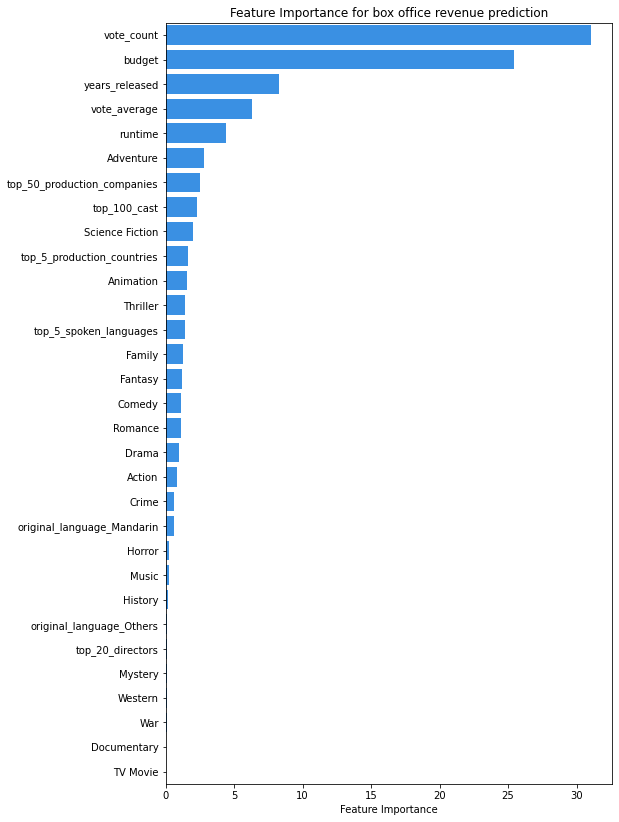

In [27]:
#feature importance plot
imp_feat = pd.DataFrame(data=final_model.feature_importances_, 
                        index=X.columns, 
                        columns=['Feature Importance']).sort_values('Feature Importance',ascending=False)

plt.figure(figsize=(8,14))
sns.barplot(data=imp_feat, y=imp_feat.index, x='Feature Importance', color='dodgerblue')

plt.title("Feature Importance for box office revenue prediction");

The feature importance plot shows that the number of votes and movie budget were the 2 strongest predictor variables for box office revenue.

## Conclusion

The final Catboost model achieved a RMSE score of 69,251,600 and a R2 score of 0.7566. However, when comparing the train metrics with the test metrics, we see that there are overfitting issues with our model even after trying to. This suggest that the model should be further improved before it can be reliably used/deployed. 

#### Limitations

There were a few limitations while working on this model:
- There was insufficient data to build a robust model. We scraped movies based on the popularity section on the TMDB website using the TMDB API. However we were only able to scrape the first 500 pages and this limited us to maximum of 10,000 movies.
- Approximately half of the initial dataset had missing values within the target revenue column, which rendered it useless for modellng purposes. This contributed more to insufficient data.
- Possible inaccuracies of data. TMDB is a user-editable database which meant that the data may not be verified before being updated on the website.
- Some predictor variables may not be useful even though they are good predictors for box office revenue, such as vote_count and years_released. These information may not be useful for the stakeholders as some of the data will only be available post-production/post-release.

#### Possible improvements

- Better feature engineering on some of the original features such as cast and crew information as it is well understood that some audience may be more inclined to watch in theaters if certain cast or crew were involved in the movie
- Combine information from various platforms such as IMDB, Rotten Tomatoes and Metacritic to obtain a more robust dataset
- NLP techniques to analyze public sentiments on the movie during early stages of production.